In [26]:
import re
import pandas as pd
import csv
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

UNIPROT_LINEAGES_PATH="/scicore/home/schwede/pudziu0000/projects/gLM/data/PINDER/uniprot_lineages_annotations_1024_512.tsv"
FALSE_PRED_PREFIX="/scicore/home/schwede/pudziu0000/projects/gLM/outputs/predictions/PINDER-eubacteria/mean_pooled/catseq_"
SEED=1024

TAX_LEVELS = ["class", "order", "family", "genus", "species"]

matplotlib.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = '16'

In [27]:
# Determine, which PINDER IDs contain both bacterial proteins

def check_tax_match(tax_info, uniprot_ids, level):
    if(tax_info[uniprot_ids[0]][level] and tax_id_info[uniprot_ids[1]][level]): # check for Nones
        if(tax_info[uniprot_ids[0]][level] == tax_id_info[uniprot_ids[1]][level]): # check for match
            return 1
        else:
            return 0
    else:
        return None

def get_prediction_type(record):
    if(record["True label"] == 1 and record["Predicted label"] == 0):
        return "FN"
    elif(record["True label"] == 0 and record["Predicted label"] == 1):
        return "FP"
    elif(record["True label"] == 1 and record["Predicted label"] == 1):
        return "TP"
    elif(record["True label"] == 0 and record["Predicted label"] == 0):
        return "TN"

def get_tax_df_from_predictions(file_prefix):
    tax_matches_arr = []
    for biolm in ["gLM2", "ESM2", "MINT"]:
        tax_matches = {"complex_id": [], "class": [], "order": [], "family": [], "genus": [], "species": [], "prediction_type": [], "truth": []}
        predictions = pd.read_csv(f"{file_prefix}{biolm}.tsv", sep='\t')
        for i, row in predictions.iterrows():
            tax_matches["complex_id"].append(predictions["Complex ID"][i])
            tax_matches["truth"].append(predictions["True label"][i])
            tax_matches["prediction_type"].append(get_prediction_type(row))
            uniprot_r = predictions["Complex ID"][i].split("_")[3]
            uniprot_l = predictions["Complex ID"][i].split("_")[7]
            for level in TAX_LEVELS:
                tax_matches[level].append(check_tax_match(tax_id_info, [uniprot_r, uniprot_l], level))
        tax_matches_arr.append(tax_matches)

    tax_dfs = []
    
    for i in range(len(tax_matches_arr)):
        tax_dfs.append(pd.DataFrame.from_dict(tax_matches_arr[i]))
        
    return tax_dfs, tax_matches_arr

def get_tax_df_from_dataset(file_prefix, split="test"):
    tax_matches = {"complex_id": [], "class": [], "order": [], "family": [], "genus": [], "species": [], "truth": []}
    data = pd.read_csv(f"{file_prefix}/{split}.txt", sep='\t')
    for i, row in data.iterrows():
        tax_matches["complex_id"].append(f"{data['protein1'][i]}_{data['protein2'][i]}")
        tax_matches["truth"].append(data["label"][i])
        uniprot_r = data["protein1"][i].split("_")[-1]
        uniprot_l = data["protein2"][i].split("_")[-1]
        for level in TAX_LEVELS:
            tax_matches[level].append(check_tax_match(tax_id_info, [uniprot_r, uniprot_l], level))
    tax_df = pd.DataFrame.from_dict(tax_matches)
    return tax_df

# Make predictor based on taxonomy level match

def get_predictions_based_on_tax_level(tax_df, n_iter=1, verbose=True):
    metrics = []
    for level in TAX_LEVELS:
        tax_df_cp = tax_df.copy()
        tax_df_cp = tax_df_cp.dropna(subset=[level])
        if(verbose):
            print(f"{level} MCC: {matthews_corrcoef(tax_df_cp['truth'], tax_df_cp[level])}")
            print(f"# predictions: {len(tax_df_cp['truth'])}")
            print(f"\tpred 0\tpred 1")
            tn, fp, fn, tp = confusion_matrix(tax_df_cp["truth"], tax_df_cp[level]).ravel()
            print(f"true 0\t{tn}\t{fp}")
            print(f"true 1\t{fn}\t{tp}")
            print()
        metrics.append([])
        for i in range(n_iter):
            y_true, y_pred = resample(tax_df_cp['truth'], tax_df_cp[level], random_state=i)
            metric = matthews_corrcoef(y_true, y_pred)
            metrics[-1].append(metric)
    return metrics
            
def make_violinplots(metrics, fig_name, title=None):
    plt.clf()
    
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.set_axisbelow(True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.8)
    
    palette = sns.color_palette("Set2")
    
    # Create violin plot
    vp = ax.violinplot(metrics, showextrema=False, showmedians=True)
    
    vp['cmedians'].set_color('black')
    for i, body in enumerate(vp['bodies']):
        body.set_facecolor(palette[i])
        body.set_edgecolor('black')
        body.set_alpha(0.8)
    
    alpha = 100-95
    for i, m in enumerate(metrics):
        lower_ci = np.percentile(m, alpha/2)
        upper_ci = np.percentile(m, 100-alpha/2)
        print(f"{lower_ci:.3f}\t{np.median(m):.3f}\t{upper_ci:.3f}")
        plt.vlines(i+1, lower_ci, upper_ci, linestyle="-", color="black")
    
    ax.set_ylim((-1.1, 1.1))
    ax.set_xticks(range(1, len(metrics)+1), TAX_LEVELS)
    plt.grid(True, linestyle="--", alpha=0.5)
    if(not title):
        plt.title("MCC of taxonomy level-based predictors", wrap=True)
    else:
        plt.title(title, wrap=True)
    
    plt.tight_layout()
    plt.savefig(f"./{fig_name}.png", dpi=300)

In [28]:
# Determine, which UniProt IDs are belonging to eubacteria with labelled phylum
lineages = pd.read_csv(UNIPROT_LINEAGES_PATH, sep='\t')

tax_id_info = {}

for index, row in lineages.iterrows():
    if isinstance(row['Taxonomic lineage (Ids)'], str) and "2 (superkingdom)" in row['Taxonomic lineage (Ids)']: 
        class_ = re.search(r'(\d+) \(class\)', row['Taxonomic lineage (Ids)'])
        order = re.search(r'(\d+) \(order\)', row['Taxonomic lineage (Ids)'])
        family = re.search(r'(\d+) \(family\)', row['Taxonomic lineage (Ids)'])
        genus = re.search(r'(\d+) \(genus\)', row['Taxonomic lineage (Ids)'])
        species = re.search(r'(\d+) \(species\)', row['Taxonomic lineage (Ids)'])
        class_ = class_.group(1) if(class_) else None
        order = order.group(1) if(order) else None
        family = family.group(1) if(family) else None
        genus = genus.group(1) if(genus) else None
        species = species.group(1) if(species) else None
        tax_id_info_dict = {"class": class_, "order": order, "family": family, "genus": genus, "species": species}
        tax_id_info[row['From']] = tax_id_info_dict

tax_dfs, tax_matches_arr = get_tax_df_from_predictions(FALSE_PRED_PREFIX)

In [29]:
tax_df = pd.DataFrame.from_dict(tax_matches_arr[0])

In [30]:
tax_df

,complex_id,class,order,family,genus,species,prediction_type,truth
0,8ap0__A1_A0A5S9CYM0_5cyy__B1_P9WG63,1,0.0,0.0,0.0,NaN,TN,0
1,1wat__B1_P02941_1wat__A1_P02941,1,1.0,1.0,1.0,1.0,TP,1
2,6xrb__A1_A0A0H3NHS6_6xrb__B1_A0A0H3NHS6,1,1.0,1.0,1.0,1.0,TP,1
3,4u66__A1_A8MI53_4wkz__B1_W5IDC3,1,0.0,0.0,0.0,NaN,TN,0
4,1dv1__A1_P24182_1dv1__B1_P24182,1,1.0,1.0,1.0,1.0,TP,1
...,...,...,...,...,...,...,...,...
1575,1d0v__A1_Q05603_1d0v__A2_Q05603,1,1.0,1.0,1.0,1.0,TP,1
1576,4h5b__A1_Q9RUY5_4h5b__B1_Q9RUY5,1,1.0,1.0,1.0,1.0,TP,1
1577,8bfr__A1_P30177_8bfr__A2_P30177,1,1.0,1.0,1.0,1.0,TP,1
1578,8jh0__B1_S2D3K4_8jh0__A1_S2D3K4,1,1.0,1.0,1.0,1.0,TP,1


In [31]:
# Use statistical test to evaluate the significance of separation of taxonomy levels

from scipy.stats import f_oneway
import numpy as np

for i, biolm in enumerate(["gLM2", "ESM2", "MINT"]):
    stats = {"group": [], "class": [], "order": [], "family": [], "genus": [], "species": []}
    tax_df = pd.DataFrame.from_dict(tax_matches_arr[i])
    for group in [["TP", "TN"], ["TP", "FN"], ["TN", "FP"], ["TP", "FP"]]:
        stats["group"].append(f"{group[0]}_{group[1]}")
        for level in TAX_LEVELS:
            if(len(set(tax_df[tax_df["prediction_type"] == group[0]][level].dropna())) == 1 and 
               len(set(tax_df[tax_df["prediction_type"] == group[1]][level].dropna())) == 1):
                stats[level].append(np.nan)
            else:
                stat, p = f_oneway(tax_df[tax_df["prediction_type"] == group[0]][level].dropna(), tax_df[tax_df["prediction_type"] == group[1]][level].dropna())
                stats[level].append(p < 0.05)
    stats_df = pd.DataFrame.from_dict(stats)
    print(biolm)
    print(stats_df)
            

gLM2
   group  class  order  family  genus  species
0  TP_TN   True   True    True   True     True
1  TP_FN   True   True    True   True     True
2  TN_FP  False  False   False  False    False
3  TP_FP   True   True    True   True     True
ESM2
   group  class  order  family  genus  species
0  TP_TN   True   True    True   True     True
1  TP_FN   True   True    True   True     True
2  TN_FP  False  False   False  False    False
3  TP_FP   True   True    True   True     True
MINT
   group  class  order family  genus species
0  TP_TN   True   True   True   True    True
1  TP_FN   True   True   True   True    True
2  TN_FP  False  False  False  False   False
3  TP_FP   True    NaN    NaN    NaN     NaN


In [32]:
for i, biolm in enumerate(["gLM2", "ESM2", "MINT"]):
    tax_df = pd.DataFrame.from_dict(tax_matches_arr[i])
    for level in TAX_LEVELS:
        print(f"{biolm}, {level}")
        print(f"TN:\t{len(tax_df[tax_df['prediction_type'] == 'TN'][level].dropna())}")
        print(f"FN:\t{len(tax_df[tax_df['prediction_type'] == 'FN'][level].dropna())}")
        print(f"FP:\t{len(tax_df[tax_df['prediction_type'] == 'FP'][level].dropna())}")
        print(f"TP:\t{len(tax_df[tax_df['prediction_type'] == 'TP'][level].dropna())}")
        

gLM2, class
TN:	776
FN:	54
FP:	14
TP:	736
gLM2, order
TN:	774
FN:	54
FP:	14
TP:	735
gLM2, family
TN:	774
FN:	54
FP:	14
TP:	735
gLM2, genus
TN:	774
FN:	54
FP:	14
TP:	735
gLM2, species
TN:	404
FN:	31
FP:	10
TP:	546
ESM2, class
TN:	767
FN:	44
FP:	23
TP:	746
ESM2, order
TN:	765
FN:	44
FP:	23
TP:	745
ESM2, family
TN:	765
FN:	44
FP:	23
TP:	745
ESM2, genus
TN:	765
FN:	44
FP:	23
TP:	745
ESM2, species
TN:	401
FN:	27
FP:	13
TP:	550
MINT, class
TN:	788
FN:	59
FP:	2
TP:	731
MINT, order
TN:	786
FN:	59
FP:	2
TP:	730
MINT, family
TN:	786
FN:	59
FP:	2
TP:	730
MINT, genus
TN:	786
FN:	59
FP:	2
TP:	730
MINT, species
TN:	412
FN:	36
FP:	2
TP:	541


class MCC: 0.42281287371840015
# predictions: 1580
	pred 0	pred 1
true 0	242	548
true 1	1	789

order MCC: 0.699144667808426
# predictions: 1577
	pred 0	pred 1
true 0	519	269
true 1	1	788

family MCC: 0.7942674453491199
# predictions: 1577
	pred 0	pred 1
true 0	611	177
true 1	1	788

genus MCC: 0.8338451122629497
# predictions: 1577
	pred 0	pred 1
true 0	649	139
true 1	2	787

species MCC: 0.820334791672207
# predictions: 991
	pred 0	pred 1
true 0	324	90
true 1	1	576

0.395	0.422	0.448
0.671	0.700	0.728
0.769	0.794	0.821
0.810	0.834	0.859
0.786	0.819	0.853


<Figure size 1920x1440 with 0 Axes>

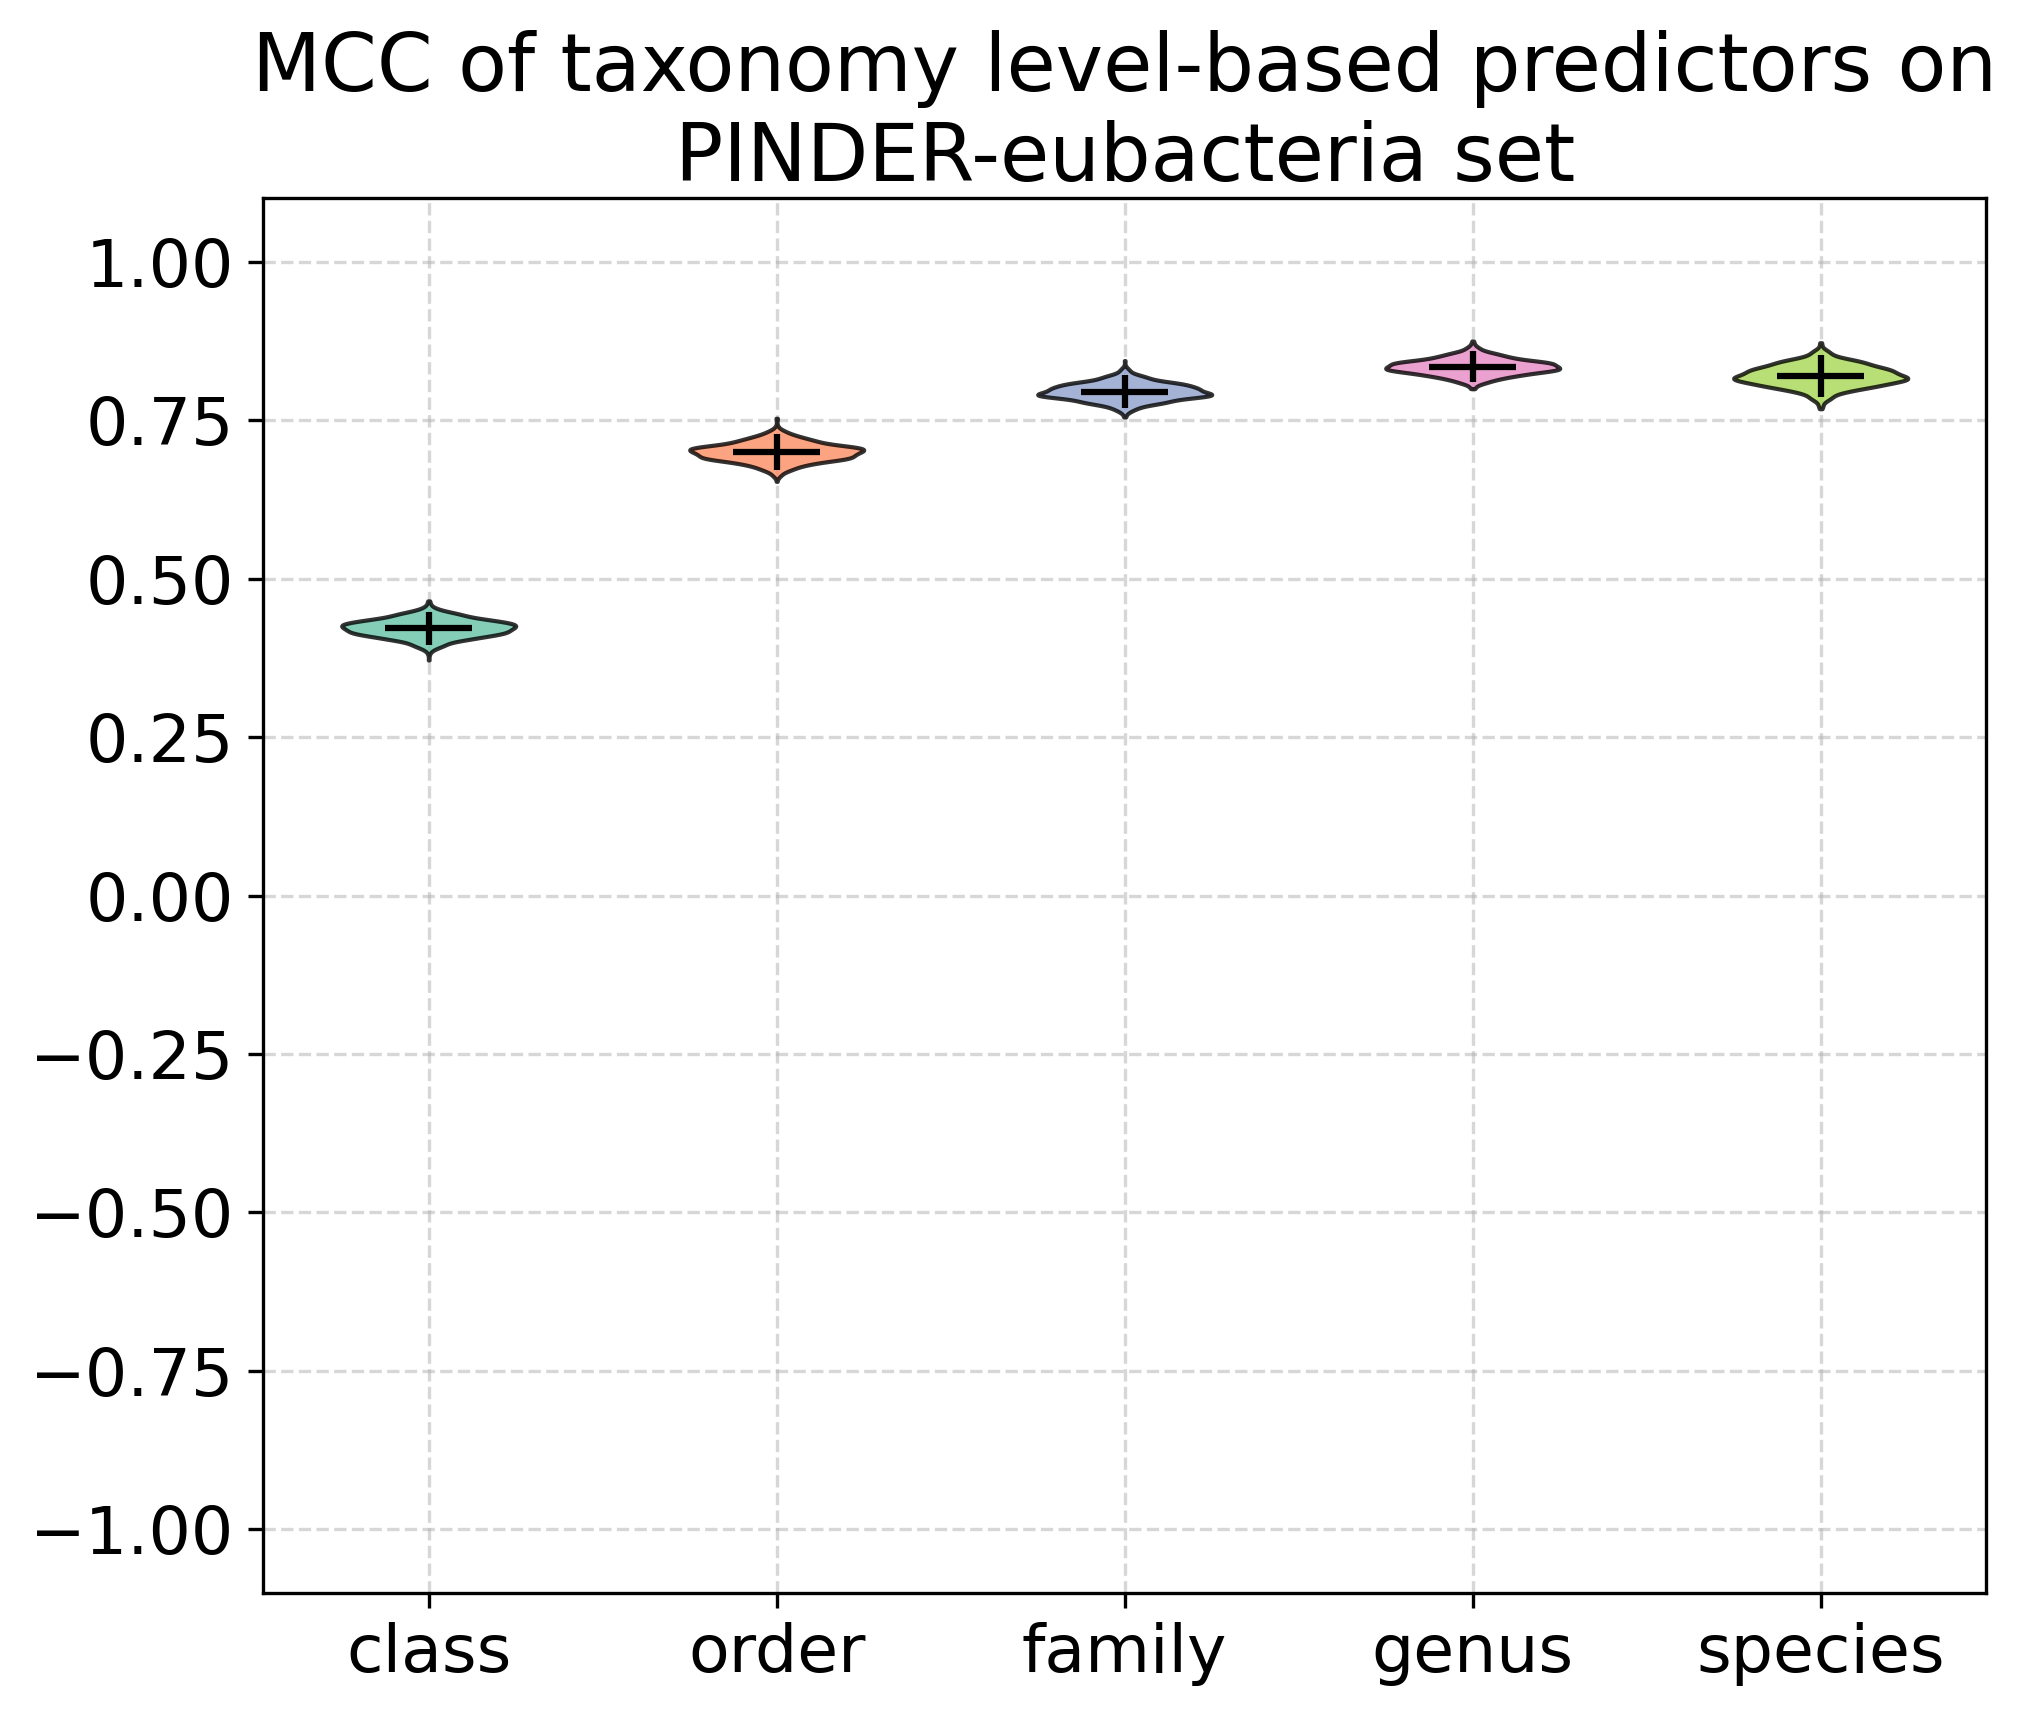

In [33]:
# Make a predictions based on the taxonomy level match
metrics = get_predictions_based_on_tax_level(tax_df, n_iter=1000)
make_violinplots(metrics, "taxonomy_level_based_predictor", title="MCC of taxonomy level-based predictors on PINDER-eubacteria set")

class MCC: 0.0
# predictions: 1010
	pred 0	pred 1
true 0	1	504
true 1	1	504

order MCC: 0.0
# predictions: 1010
	pred 0	pred 1
true 0	1	504
true 1	1	504

family MCC: 0.0
# predictions: 1010
	pred 0	pred 1
true 0	1	504
true 1	1	504

genus MCC: 0.0
# predictions: 1010
	pred 0	pred 1
true 0	1	504
true 1	1	504

species MCC: 0.29996140155235557
# predictions: 671
	pred 0	pred 1
true 0	45	253
true 1	0	373

-0.046	0.000	0.053
-0.046	0.000	0.053
-0.046	0.000	0.053
-0.046	0.000	0.053
0.258	0.300	0.346


<Figure size 1920x1440 with 0 Axes>

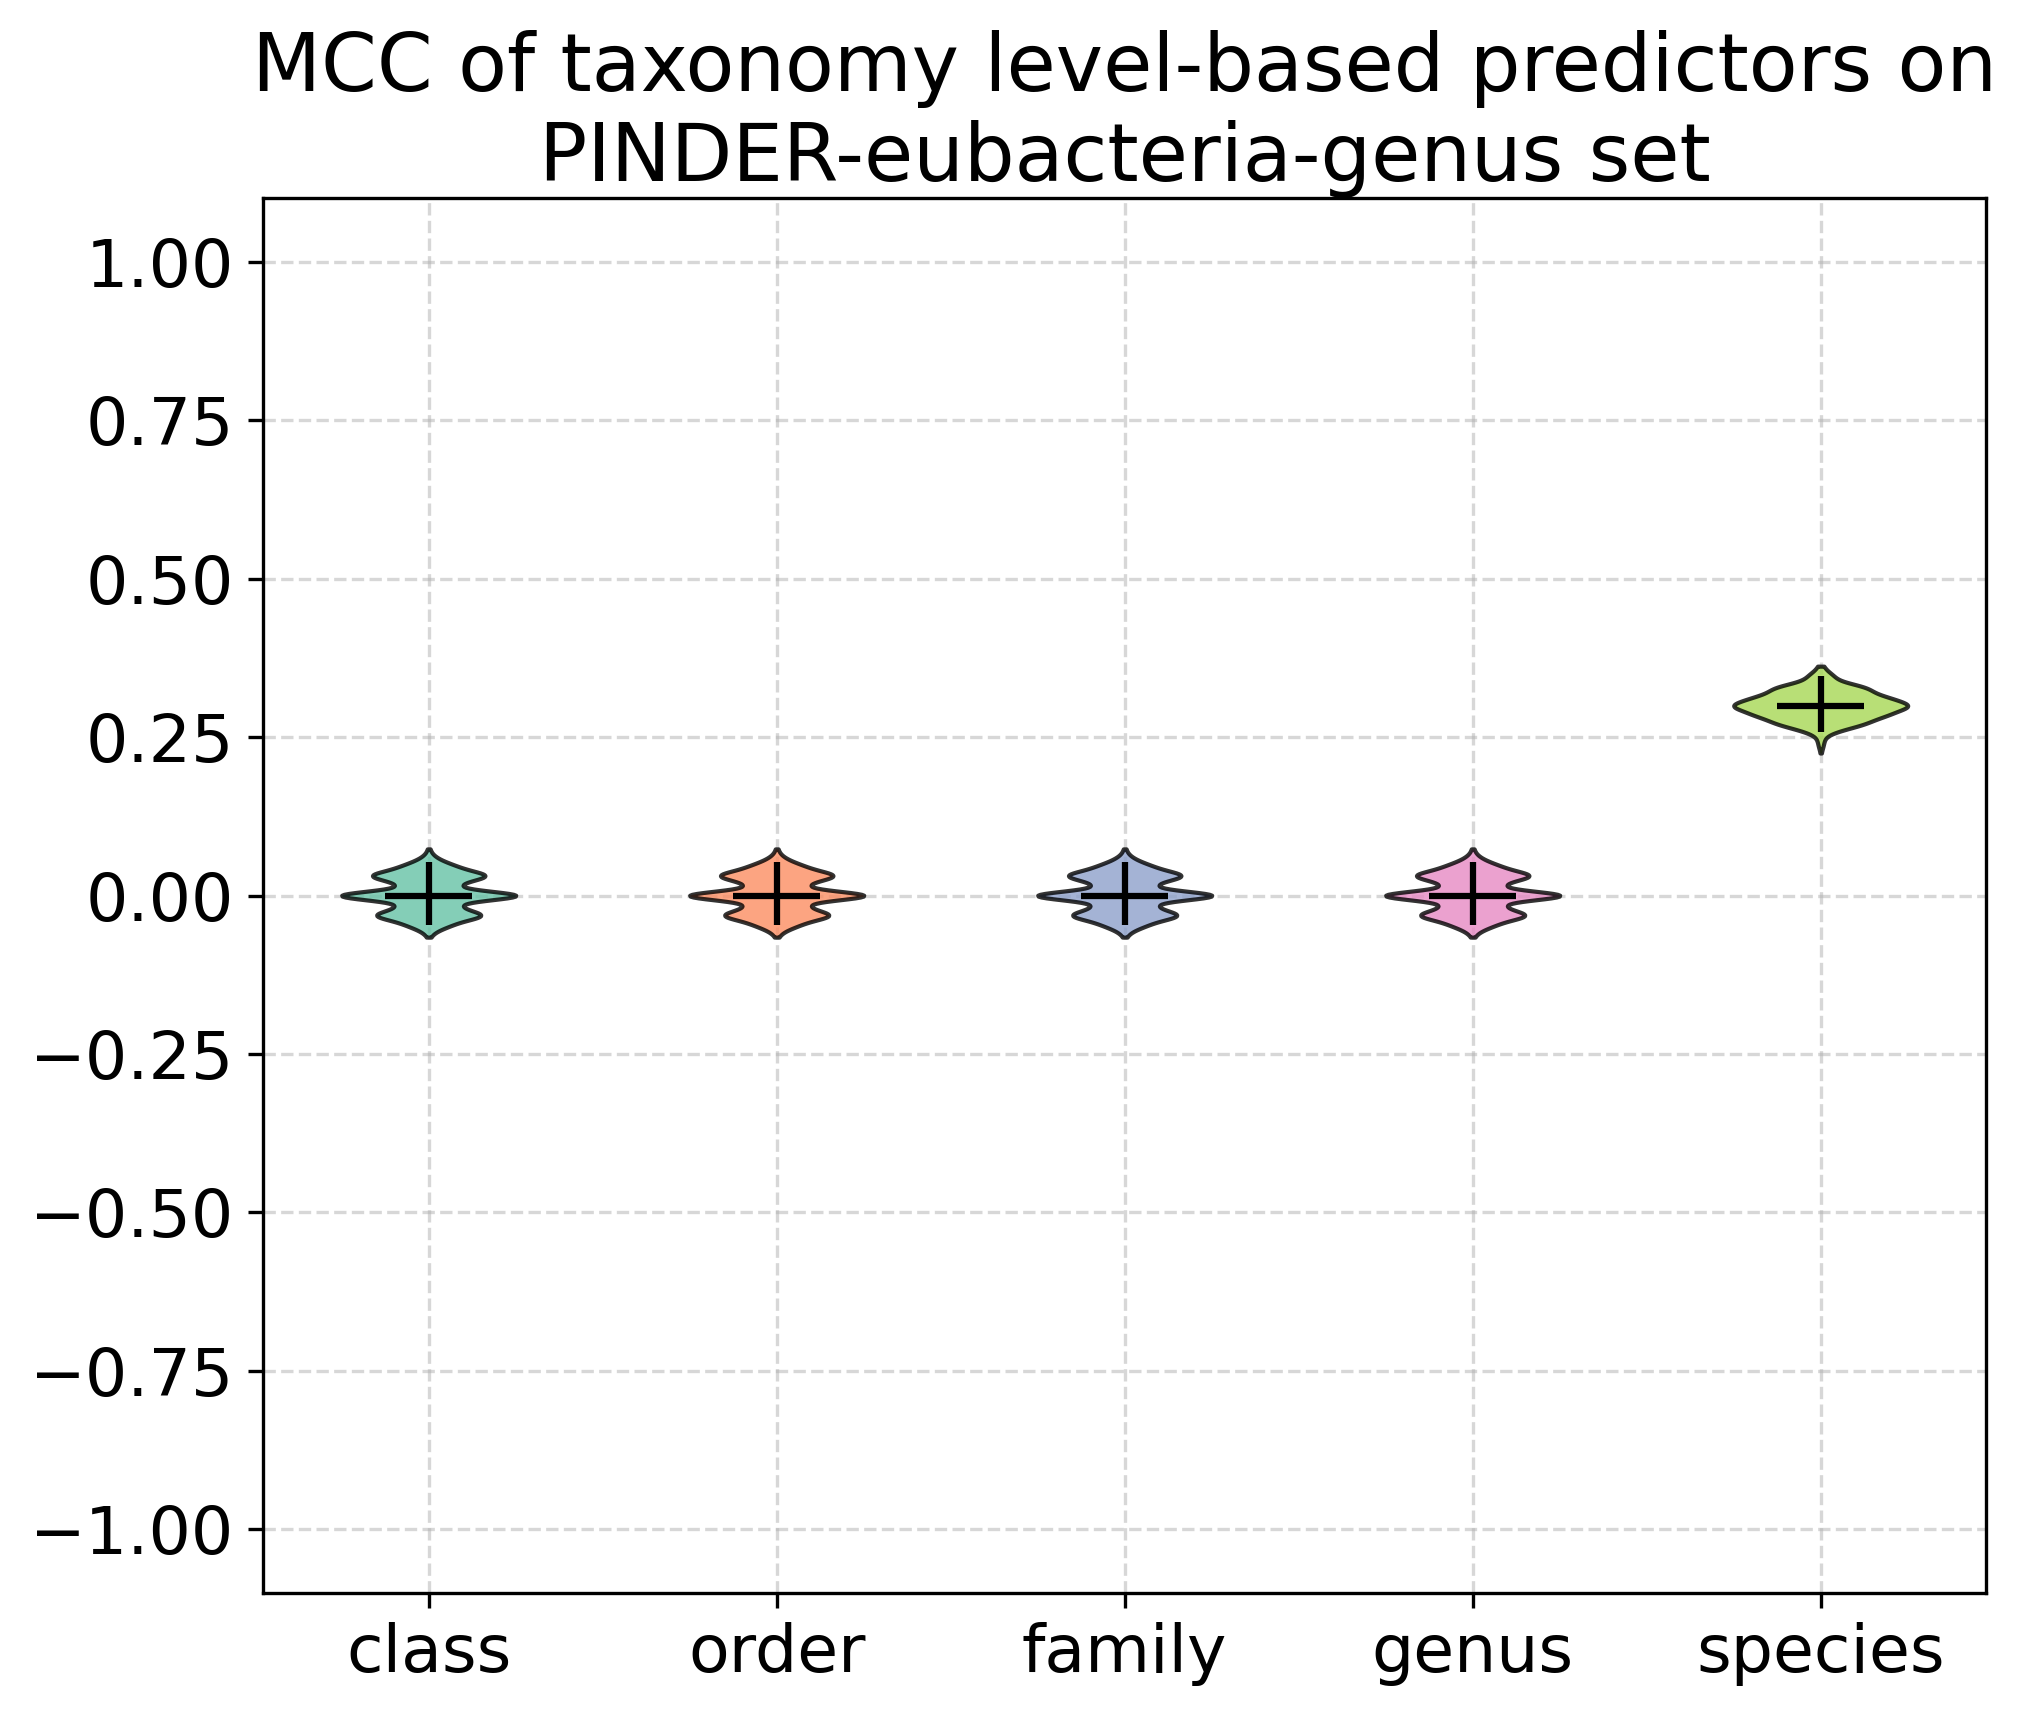

In [34]:
DATASET_PREFIX="/scicore/home/schwede/pudziu0000/projects/gLM/data/PINDER/eubacteria_5_1024_512_genus/"

tax_df = get_tax_df_from_dataset(DATASET_PREFIX, split="test")

metrics = get_predictions_based_on_tax_level(tax_df, n_iter=1000)

make_violinplots(metrics, "taxonomy_level_based_predictor_within_genus", title="MCC of taxonomy level-based predictors on PINDER-eubacteria-genus set")

class MCC: 0.0
# predictions: 664
	pred 0	pred 1
true 0	0	332
true 1	0	332

order MCC: 0.0
# predictions: 664
	pred 0	pred 1
true 0	0	332
true 1	0	332

family MCC: 0.0
# predictions: 664
	pred 0	pred 1
true 0	0	332
true 1	0	332

genus MCC: -0.03883678186903087
# predictions: 664
	pred 0	pred 1
true 0	0	332
true 1	1	331

species MCC: -0.03883678186903087
# predictions: 664
	pred 0	pred 1
true 0	0	332
true 1	1	331

0.000	0.000	0.000
0.000	0.000	0.000
0.000	0.000	0.000
-0.069	-0.038	0.000
-0.069	-0.038	0.000


<Figure size 1920x1440 with 0 Axes>

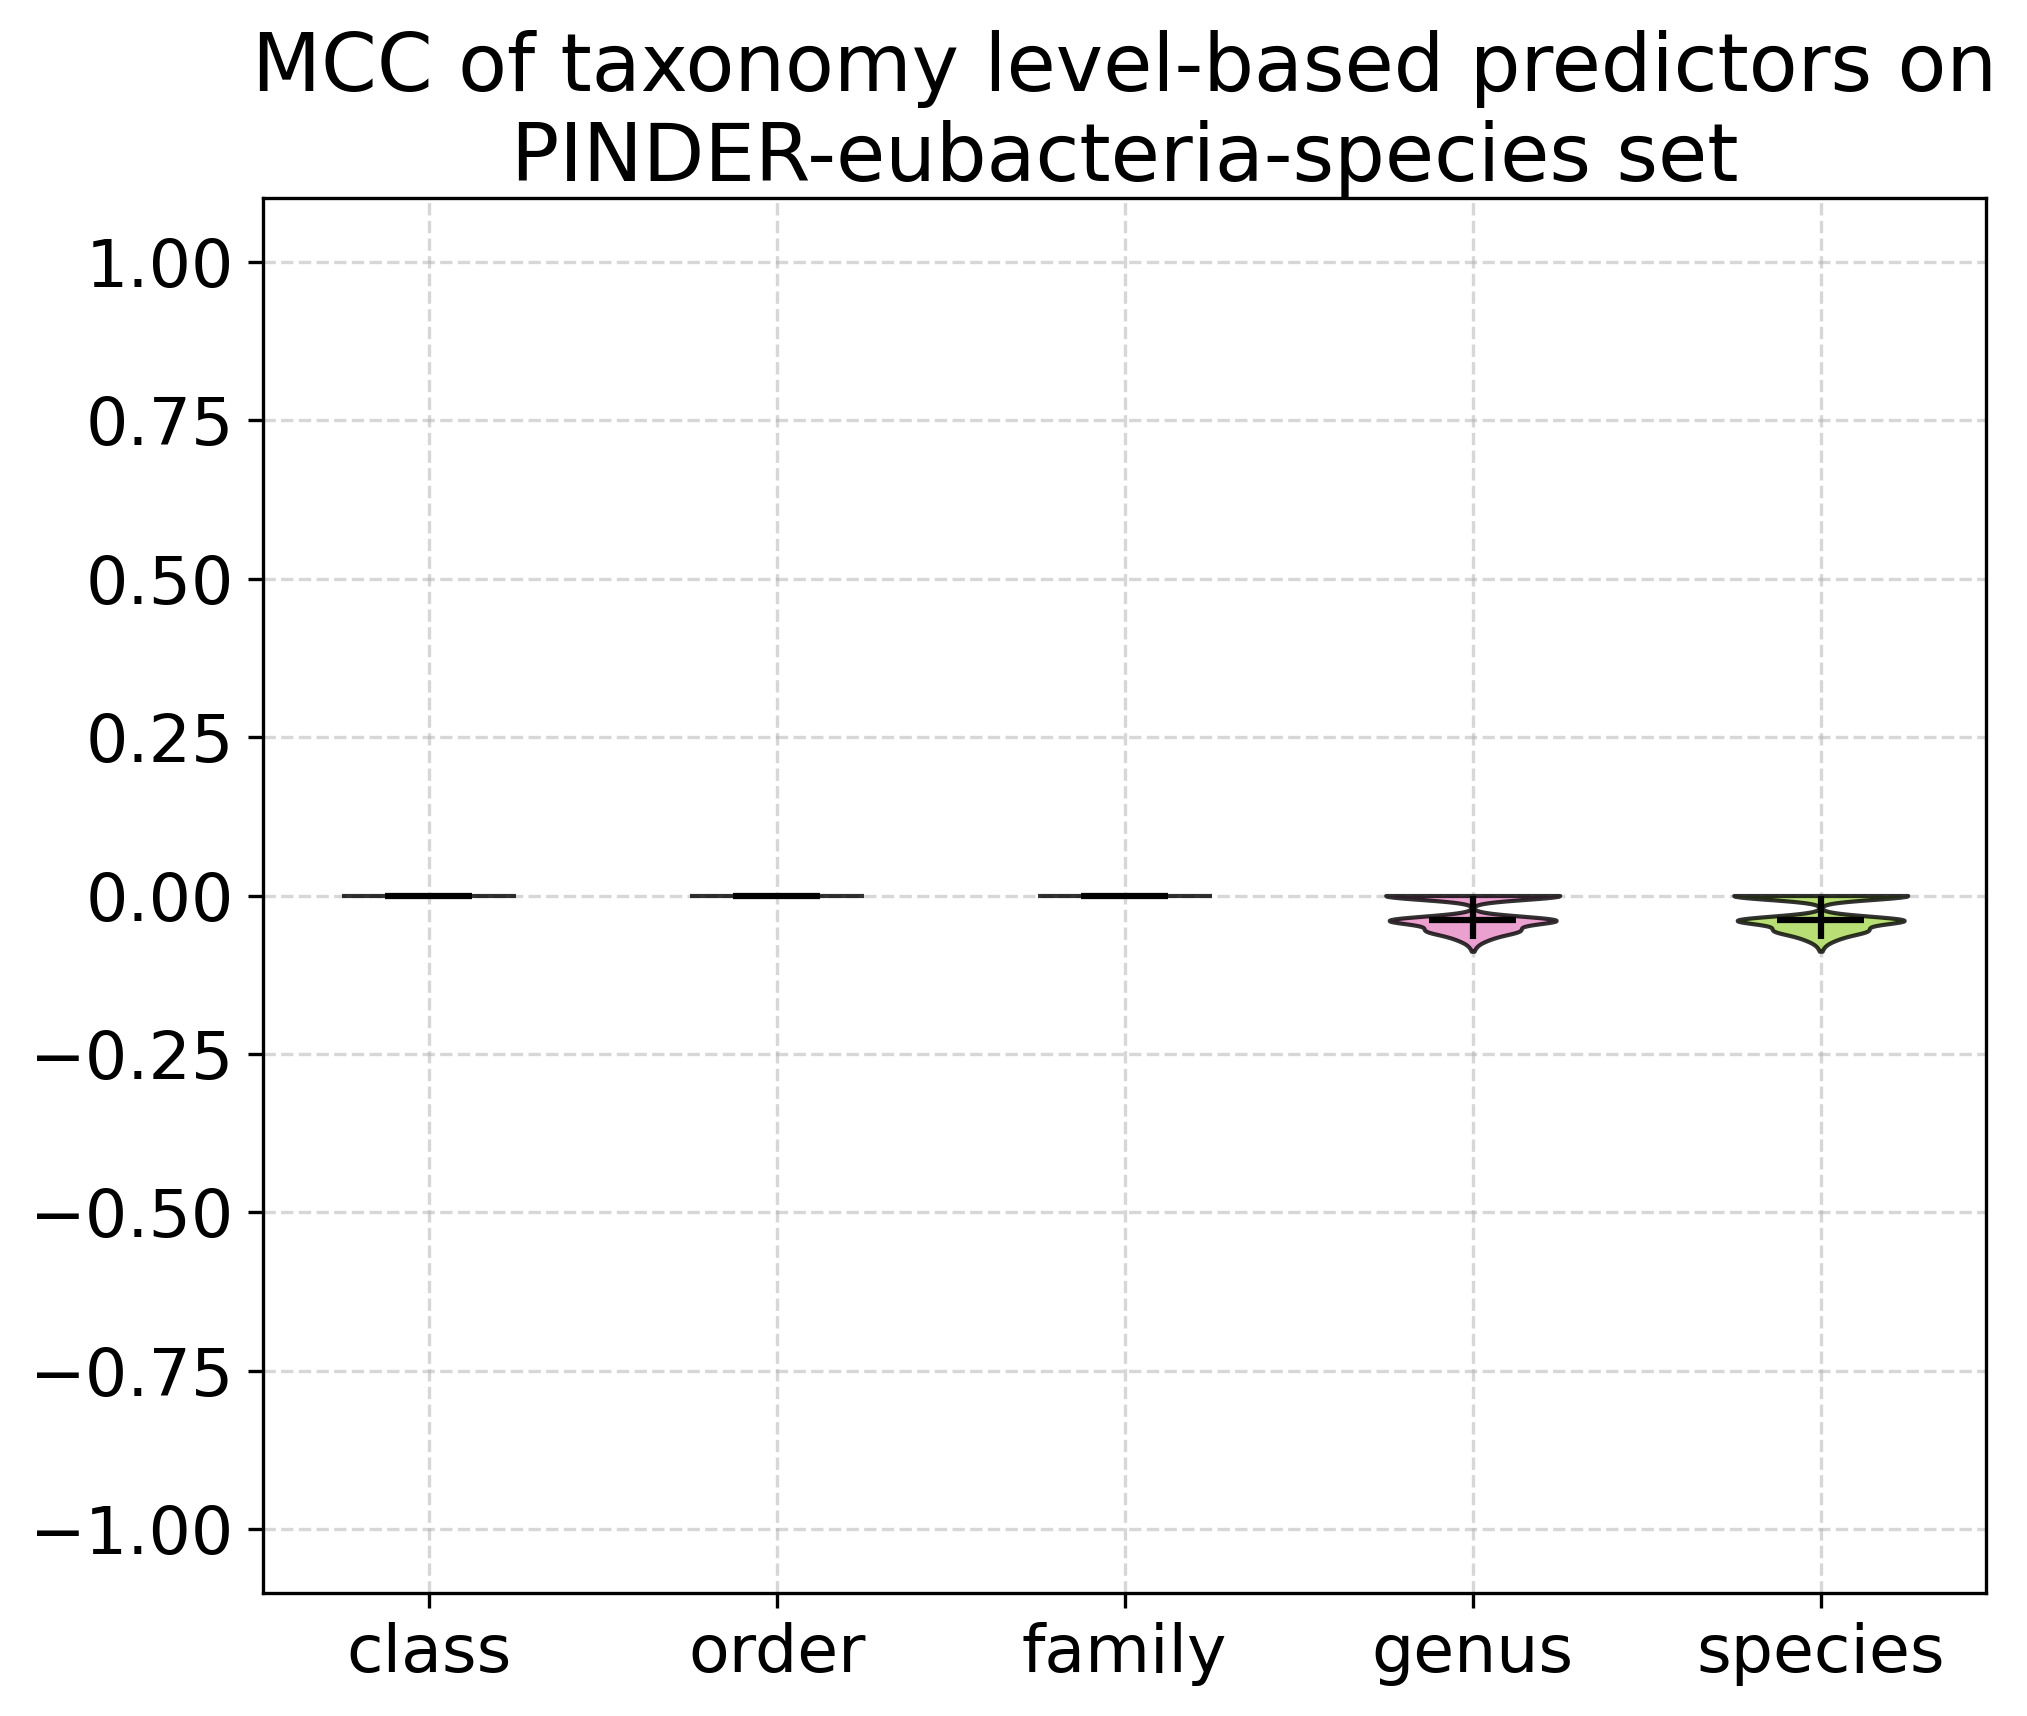

In [35]:
DATASET_PREFIX="/scicore/home/schwede/pudziu0000/projects/gLM/data/PINDER/eubacteria_5_1024_512_species/"

tax_df = get_tax_df_from_dataset(DATASET_PREFIX, split="test")

metrics = get_predictions_based_on_tax_level(tax_df, n_iter=1000)

make_violinplots(metrics, "taxonomy_level_based_predictor_within_species", title="MCC of taxonomy level-based predictors on PINDER-eubacteria-species set")